In [88]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lib

In [91]:
core2_cfg = lib.FinnParams.from_dict(is_exp_data=True, **lib.load_exp_conf("Core 2"))
core2b_cfg = lib.FinnParams.from_dict(is_exp_data=True, **lib.load_exp_conf("Core 2B"))

data_core2 = lib.load_exp_data("Core 2")
data_core2b = lib.load_exp_data("Core 2B")

In [92]:
core2_cfg.Nx, core2b_cfg.Nx, core2_cfg.cauchy_mult

(20, 30, [0.006063272660207464, 0.006063272660207464])

In [93]:
u = np.linspace(0, 2, 501)
physical_model_ret = np.loadtxt(
    "/Users/r/Documents/dev/tmp/finn_repo_comparisions/cogni_finn/sampling/retardation_phys.txt"
)[::4]

profile_data_core2b = data_core2b["c_tot"]
profile_x_core2b = data_core2b["x"]

breakthrough_data_core2 = data_core2["c_diss"]
breakthrough_time_core2 = data_core2["time"]

In [94]:
def make_plot_grid(n_axis: int, ncols: int, **kwargs):
    nrows = int(np.ceil(n_axis / ncols))
    return plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(4 * ncols, 4 * nrows), **kwargs
    )

In [95]:
root_dir = Path(
    "/Users/r/Documents/dev/tmp/finn_repo_comparisions/cogni_finn/sampling/finndirs2/"
)

In [96]:
MSE_THRESHOLD = 0.05

In [97]:
def btc_from_full_field(c_full):
    A = np.pi * 0.02375**2
    Q = 0.00010435199999999999
    cm = lib.load_exp_conf("Core 2")["por"] * A / Q
    cauchy_mult = cm * core2_cfg.D_eff[0] * core2_cfg.dx
    btc = (c_full[1:, -2, 0] - c_full[1:, -1, 0]) * cauchy_mult
    # print("MAX: ", c_full.max(), "BTC: ", btc.max())
    return btc#*1000

def normalized_mse(input, target):
    return np.square(input - target).mean() / np.square(target).max()

In [98]:
# compute all profiles
for finn_dir in root_dir.iterdir():
    for ret_path in finn_dir.glob("retPred_*.npy"):
        epoch = int(ret_path.stem.split("_")[-1])
        p = finn_dir / f"cProfile_{epoch}.npy"
        if p.exists():
            continue
        print(f"Computing cProfile for epoch {epoch}...")
        c_profile = lib.compute_core2B_profile_simple(u, np.load(ret_path))
        np.save(p, c_profile)

In [113]:
records = []
for finn_dir in root_dir.iterdir():
    ret = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("retPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )
    c = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("cPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )
    if ret.shape == (0,):
        print(ret.shape)
        continue
    if ret.shape[0] < 100:
        print(ret.shape)
        continue

    loss = np.loadtxt(finn_dir / "loss.txt")
    y_train = np.load(finn_dir / "y_train.npy")
    y_pred = np.load(finn_dir / "y_pred.npy")

    btc_mse = normalized_mse(y_pred, y_train)

    all_btc_mses = [normalized_mse(btc_from_full_field(np.load(finn_dir / f"cPred_{i}.npy")), y_train) for i in range(100)]
    all_profile_mses = [normalized_mse(np.load(finn_dir / f"cProfile_{i}.npy")[1:], data_core2b["c_tot"][1:]) for i in range(100)]
    
    # if np.argmin(all_btc_mses) == 0:
    #     plt.plot(y_train, "-o")
    #     for i in range(100):
    #         btc = btc_from_full_field(np.load(finn_dir / f"cPred_{i}.npy"))*1000
    #         plt.plot(btc, "k-", alpha=0.1)
    #         plt.plot(y_pred, "r-", alpha=0.1)
    #     print(all_btc_mses)
    #     print(normalized_mse(btc, y_train))
    #     print()
    #     plt.show()
    #     raise ValueError()

    records.append(
        {
            "path": finn_dir,
            "best_mse_index_btc": np.argmin(all_btc_mses),
            "best_mse_index_profile": np.argmin(all_profile_mses),
            "last_loss": loss[-1],
            "btc_mse": btc_mse,
            "min_btc_mse": np.min(all_btc_mses),
        }
    )

finn_dir_df = (
    pd.DataFrame.from_records(records).sort_values("btc_mse").reset_index(drop=True)
)
plt.show()

(6, 501)


In [114]:
finn_dir_df

,path,best_mse_index_btc,best_mse_index_profile,last_loss,btc_mse,min_btc_mse
0,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,24,2,0.386572,0.000592,0.000592
1,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,26,16,0.389754,0.000597,0.000597
2,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,16,7,0.404211,0.000620,0.000620
3,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,20,15,0.533400,0.000818,0.000818
4,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,14,12,1.066514,0.001635,0.001635
5,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,43,2,58.205605,0.089229,0.089229
6,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,0,0,61.166821,0.093591,0.093591
7,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,6,5,264.711884,0.405804,0.405804
8,/Users/r/Documents/dev/tmp/finn_repo_comparisi...,0,0,264.712402,0.405804,0.405804


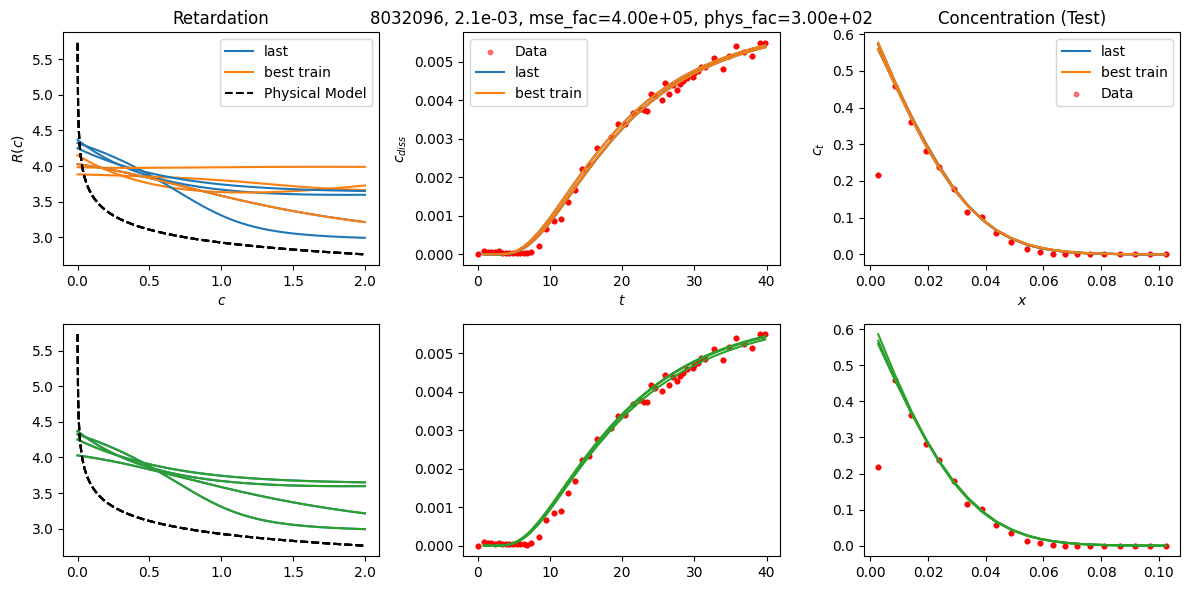

In [118]:
ncols = 3
fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(4 * ncols, 6))



for row, finn_dir in enumerate(finn_dir_df["path"]):
    df_row = finn_dir_df.iloc[row]
    if df_row["min_btc_mse"] > 0.001634:
        continue

    data_kwargs = dict(color="red", s=10, alpha=0.5, label="Data" if row==0 else "")

    # ================================
    # Retardations
    # ================================

    ret = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("retPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )

    axs[0, 0].set_title("Retardation")
    axs[0, 0].plot(u, ret[-1].T, color="C0", label="last" if row==0 else "")
    axs[1, 0].plot(u, ret[-1].T, color="C0", label="last" if row==0 else "")
    axs[0, 0].plot(u, ret[df_row["best_mse_index_profile"]].T, color="C1", label="best train" if row==0 else "")
    axs[1, 0].plot(u, ret[df_row["best_mse_index_btc"]].T, color="C2", label="best test" if row==0 else "")
    axs[0, 0].plot(u, physical_model_ret, "k--", label="Physical Model" if row==0 else "")
    axs[1, 0].plot(u, physical_model_ret, "k--", label="Physical Model" if row==0 else "")
    axs[0, 0].set_xlabel("$c$")
    axs[0, 0].set_ylabel("$R(c)$")
    axs[0, 0].legend()

    # ================================
    # Concentration (Train)
    # ================================

    c = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("cPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )

    y_train = np.load(finn_dir / "y_train.npy")
    y_pred = np.load(finn_dir / "y_pred.npy")
    config = json.loads((finn_dir / "config.json").read_text())
    mse = np.square(y_train - y_pred).mean() / np.square(y_train).mean()

    axs[1, 1].scatter(breakthrough_time_core2, breakthrough_data_core2, **data_kwargs)
    axs[0, 1].scatter(breakthrough_time_core2, breakthrough_data_core2, **data_kwargs)
    axs[0, 1].plot(breakthrough_time_core2[1:], y_pred, "-", color="C0", label="last" if row==0 else "")
    axs[0, 1].plot(breakthrough_time_core2[1:], btc_from_full_field(c[df_row["best_mse_index_btc"]]), "-", color="C1", label="best train" if row==0 else "")
    axs[1, 1].plot(breakthrough_time_core2[1:], btc_from_full_field(c[df_row["best_mse_index_profile"]]), "-", color="C2", label="best test" if row==0 else "")
    axs[0, 1].set_title(
        f"{config['seed']}, {config['lr'][0]:.1e}, mse_fac={config['loss_mse_fac']:.2e}, phys_fac={config['loss_phys_fac']:.2e}"
    )
    axs[0, 1].set_xlabel("$t$")
    axs[0, 1].set_ylabel("$c_{diss}$")
    axs[0, 1].legend()

    # ================================
    # Concentration (Test)
    # ================================


    axs[0, 2].set_title("Concentration (Test)")
    axs[0, 2].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{99}.npy"), color="C0", label="last" if row==0 else "")
    axs[0, 2].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{df_row['best_mse_index_btc']}.npy"), color="C1", label="best train" if row==0 else "")
    axs[1, 2].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{df_row['best_mse_index_profile']}.npy"), color="C2", label="best test" if row==0 else "")
    axs[1, 2].scatter(profile_x_core2b, profile_data_core2b, **data_kwargs)
    axs[0, 2].scatter(profile_x_core2b, profile_data_core2b, **data_kwargs)
    axs[0, 2].set_xlabel("$x$")
    axs[0, 2].set_ylabel("$c_t$")
    axs[0, 2].legend()

plt.tight_layout()
plt.show()

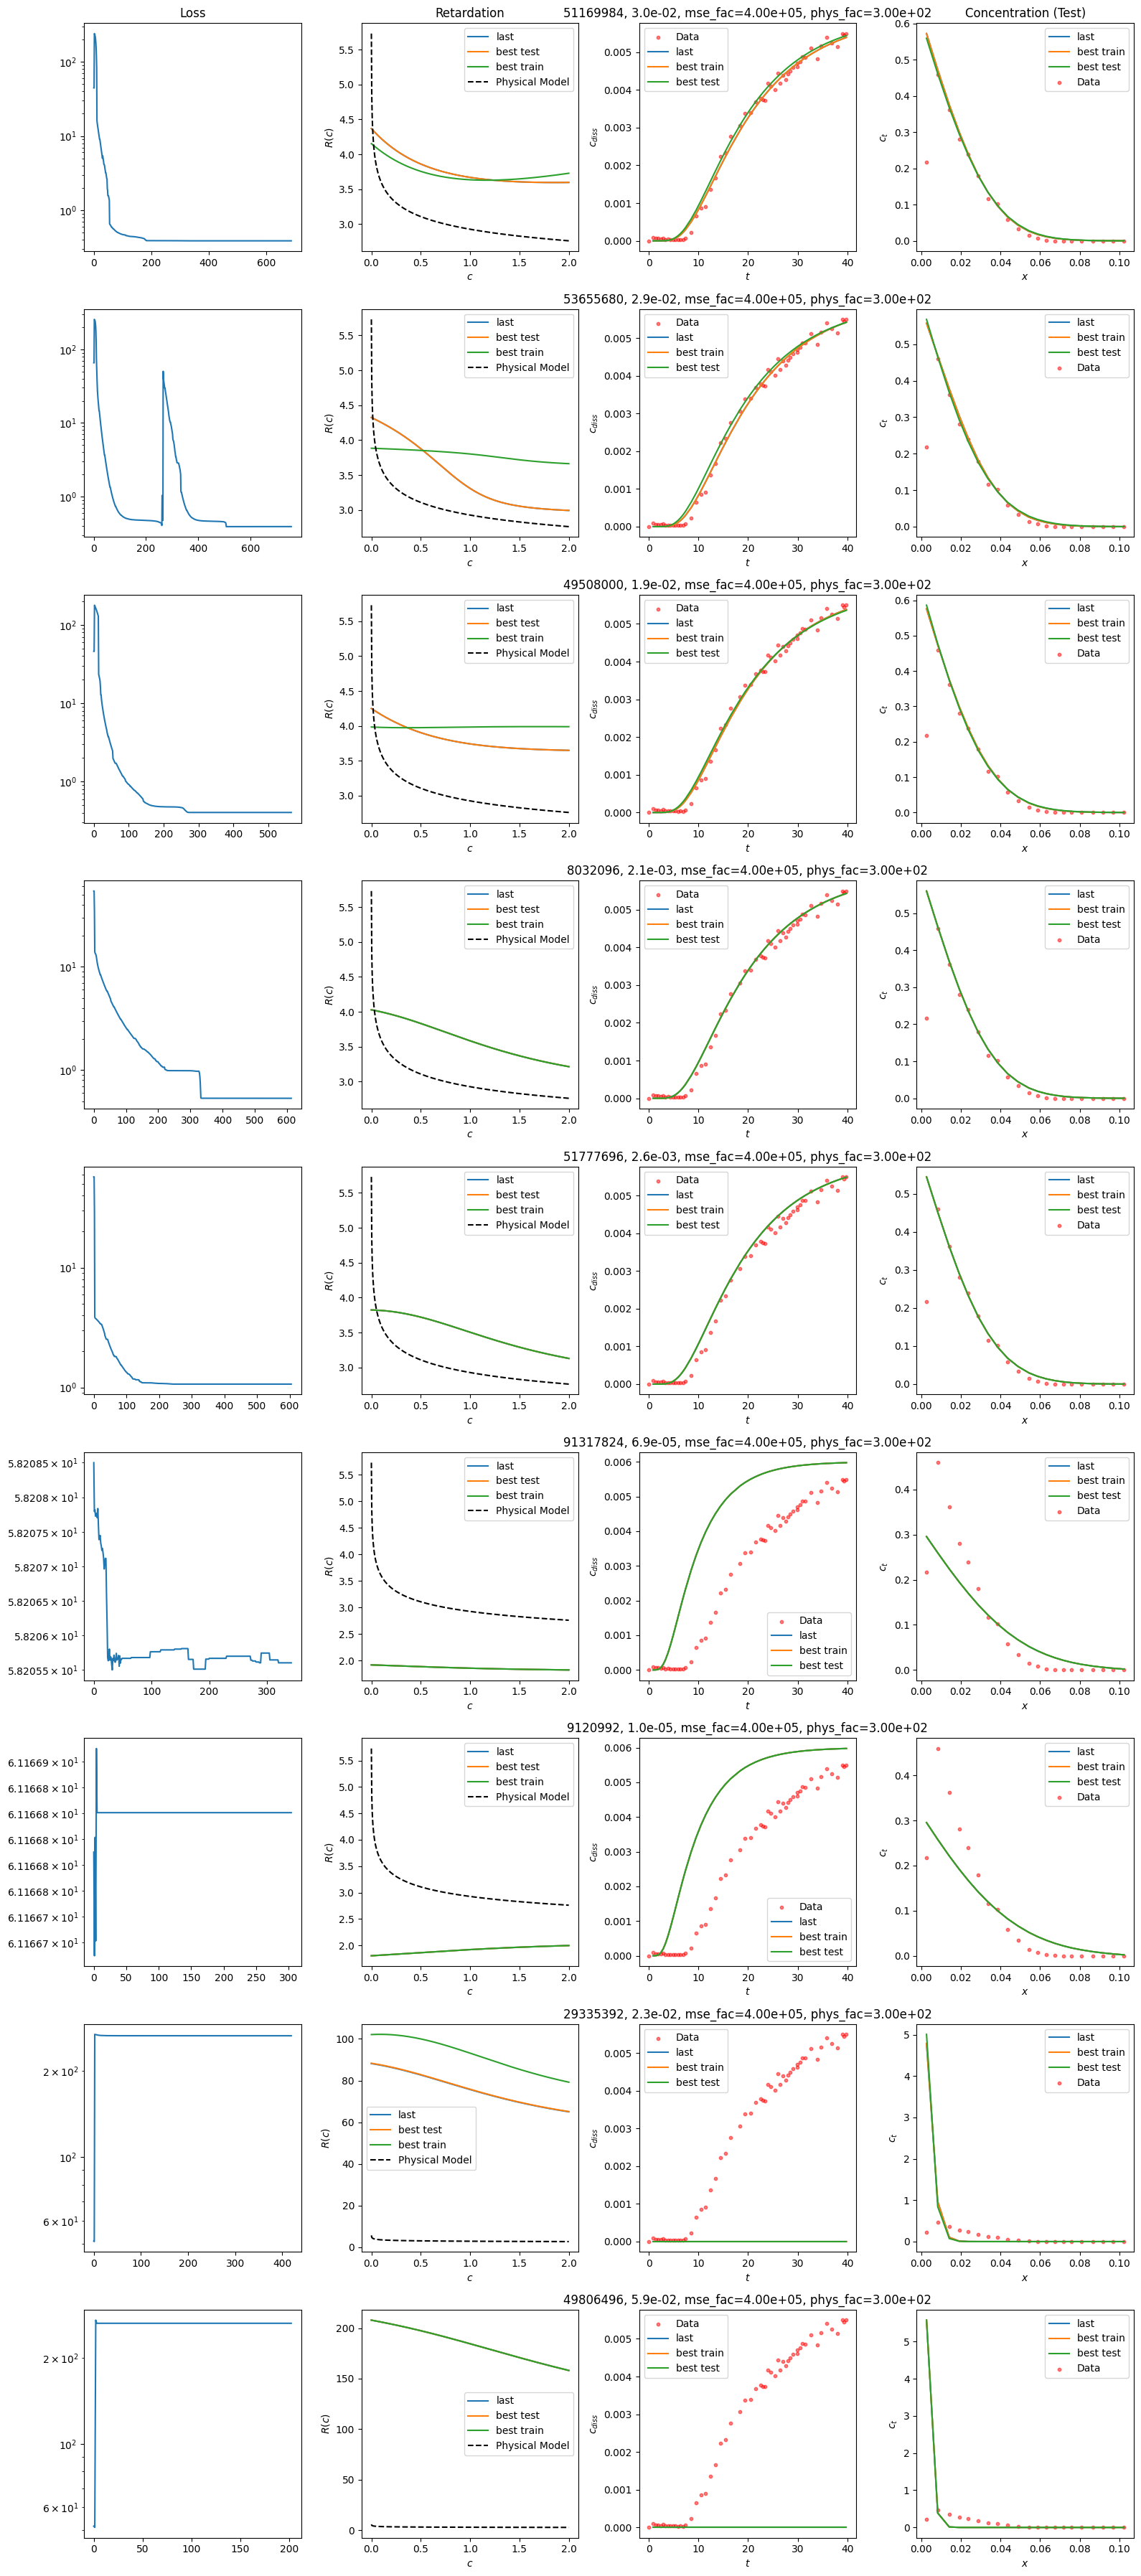

In [105]:
ncols = 4
nrows = len(finn_dir_df)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

data_kwargs = dict(color="red", label="Data", s=10, alpha=0.5)

for row, finn_dir in enumerate(finn_dir_df["path"]):
    df_row = finn_dir_df.iloc[row]

    loss = np.loadtxt(finn_dir / "loss.txt")

    axs[0, 0].set_title("Loss")
    axs[row, 0].semilogy(loss)

    # ================================
    # Retardations
    # ================================

    ret = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("retPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )

    axs[0, 1].set_title("Retardation")
    axs[row, 1].plot(u, ret[-1].T, label="last")
    axs[row, 1].plot(u, ret[df_row["best_mse_index_btc"]].T, label="best test")
    axs[row, 1].plot(u, ret[df_row["best_mse_index_profile"]].T, label="best train")
    axs[row, 1].plot(u, physical_model_ret, "k--", label="Physical Model")
    axs[row, 1].set_xlabel("$c$")
    axs[row, 1].set_ylabel("$R(c)$")
    axs[row, 1].legend()

    # ================================
    # Concentration (Train)
    # ================================

    c = np.array(
        [
            np.load(p)
            for p in sorted(
                finn_dir.glob("cPred_*.npy"), key=lambda p: int(p.stem.split("_")[-1])
            )
        ]
    )

    y_train = np.load(finn_dir / "y_train.npy")
    y_pred = np.load(finn_dir / "y_pred.npy")
    config = json.loads((finn_dir / "config.json").read_text())
    mse = np.square(y_train - y_pred).mean() / np.square(y_train).mean()

    axs[row, 2].scatter(breakthrough_time_core2, breakthrough_data_core2, **data_kwargs)
    axs[row, 2].plot(breakthrough_time_core2[1:], y_pred, "-", label="last")
    axs[row, 2].plot(breakthrough_time_core2[1:], btc_from_full_field(c[df_row["best_mse_index_btc"]]), "-", label="best train")
    axs[row, 2].plot(breakthrough_time_core2[1:], btc_from_full_field(c[df_row["best_mse_index_profile"]]), "-", label="best test")
    axs[row, 2].set_title(
        f"{config['seed']}, {config['lr'][0]:.1e}, mse_fac={config['loss_mse_fac']:.2e}, phys_fac={config['loss_phys_fac']:.2e}"
    )
    axs[row, 2].set_xlabel("$t$")
    axs[row, 2].set_ylabel("$c_{diss}$")
    axs[row, 2].legend()

    # ================================
    # Concentration (Test)
    # ================================


    axs[0, 3].set_title("Concentration (Test)")
    axs[row, 3].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{99}.npy"), label="last")
    axs[row, 3].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{df_row['best_mse_index_btc']}.npy"), label="best train")
    axs[row, 3].plot(profile_x_core2b, np.load(finn_dir / f"cProfile_{df_row['best_mse_index_profile']}.npy"), label="best test")
    axs[row, 3].scatter(profile_x_core2b, profile_data_core2b, **data_kwargs)
    axs[row, 3].set_xlabel("$x$")
    axs[row, 3].set_ylabel("$c_t$")
    axs[row, 3].legend()

plt.tight_layout()
plt.show()